In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

In [9]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType, TimestampType

# Set up Spark Session
spark = SparkSession.builder.appName("CourseRecommendationSystem").getOrCreate()



# Assuming your CSV file is uploaded, get the file name (use the correct file name here)
file_name = "/content/udemy_courses.csv"

# Load the dataset into a Spark DataFrame
schema = StructType([
    StructField("course_id", IntegerType(), True),
    StructField("course_title", StringType(), True),
    StructField("url", StringType(), True),
    StructField("is_paid", BooleanType(), True),
    StructField("price", DoubleType(), True),
    StructField("num_subscribers", IntegerType(), True),
    StructField("num_reviews", IntegerType(), True),
    StructField("num_lectures", IntegerType(), True),
    StructField("level", StringType(), True),
    StructField("content_duration", DoubleType(), True),
    StructField("published_timestamp", TimestampType(), True),
    StructField("subject", StringType(), True)
])

# Load data from the uploaded file
df = spark.read.csv(file_name, header=True, schema=schema)
df.show(5)


+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   true|200.0|           2147|         23|          51|        All Levels|             1.5|2017-01-18 20:58:58|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   true| 75.0|           2792|        923|         274|        All Levels|            39.0|2017-03-09 16:34:20|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   true| 45.0|           2174|       

In [10]:
# Count nulls in each column
from pyspark.sql.functions import col, sum

# Count nulls for each column and display
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               5|                  0|      5|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+



DATA EXPLORATION

In [11]:
# Group by course level and count
level_distribution = df.groupBy("level").count()
level_distribution.show()


+------------------+-----+
|             level|count|
+------------------+-----+
|      Expert Level|   58|
|Intermediate Level|  422|
|        All Levels| 1930|
|    Beginner Level| 1273|
+------------------+-----+



In [ ]:
# Top 5 courses by number of subscribers
top_courses = df.orderBy(df.num_subscribers.desc()).select("course_title", "num_subscribers", "price", "subject")
top_courses.show(5)


+--------------------+---------------+-----+---------------+
|        course_title|num_subscribers|price|        subject|
+--------------------+---------------+-----+---------------+
|Learn HTML5 Progr...|         268923|  0.0|Web Development|
|Coding for Entrep...|         161029|  0.0|Web Development|
|The Web Developer...|         121584|200.0|Web Development|
|Build Your First ...|         120291|  0.0|Web Development|
|The Complete Web ...|         114512|200.0|Web Development|
+--------------------+---------------+-----+---------------+
only showing top 5 rows



In [ ]:
# Calculate average price by subject
avg_price_by_subject = df.groupBy("subject").avg("price")
avg_price_by_subject.show()


+-------------------+------------------+
|            subject|        avg(price)|
+-------------------+------------------+
|   Business Finance| 68.55230125523012|
|     Graphic Design|57.827529021558874|
|    Web Development| 77.03333333333333|
|Musical Instruments| 49.55882352941177|
+-------------------+------------------+



In [ ]:
from pyspark.sql.functions import year

# Extract the year from the 'published_timestamp'
df = df.withColumn("year", year(df.published_timestamp))

# Count the number of courses published each year
courses_per_year = df.groupBy("year").count().orderBy("year")
courses_per_year.show()


+----+-----+
|year|count|
+----+-----+
|2011|    5|
|2012|   45|
|2013|  202|
|2014|  491|
|2015| 1014|
|2016| 1206|
|2017|  715|
+----+-----+



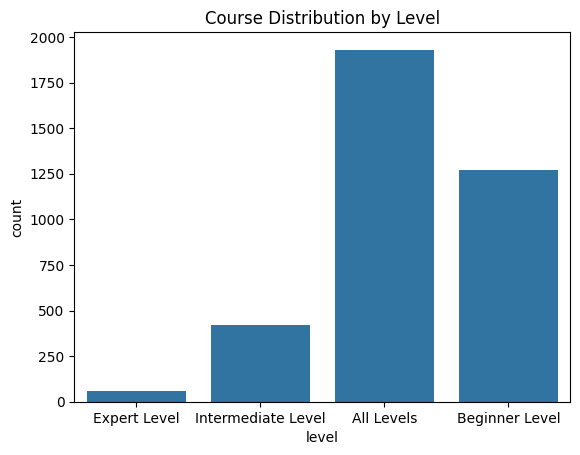

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = level_distribution.toPandas()

# Plot the distribution of courses by level
sns.barplot(x='level', y='count', data=pdf)
plt.title("Course Distribution by Level")
plt.show()


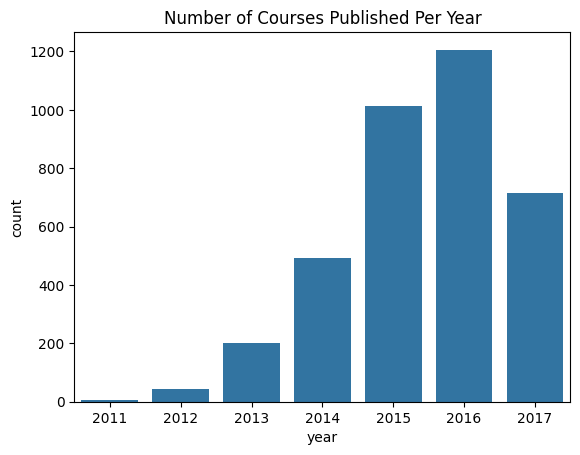

In [ ]:
# Convert to Pandas for plotting
pdf_year = courses_per_year.toPandas()

# Plot courses per year
sns.barplot(x='year', y='count', data=pdf_year)
plt.title("Number of Courses Published Per Year")
plt.show()


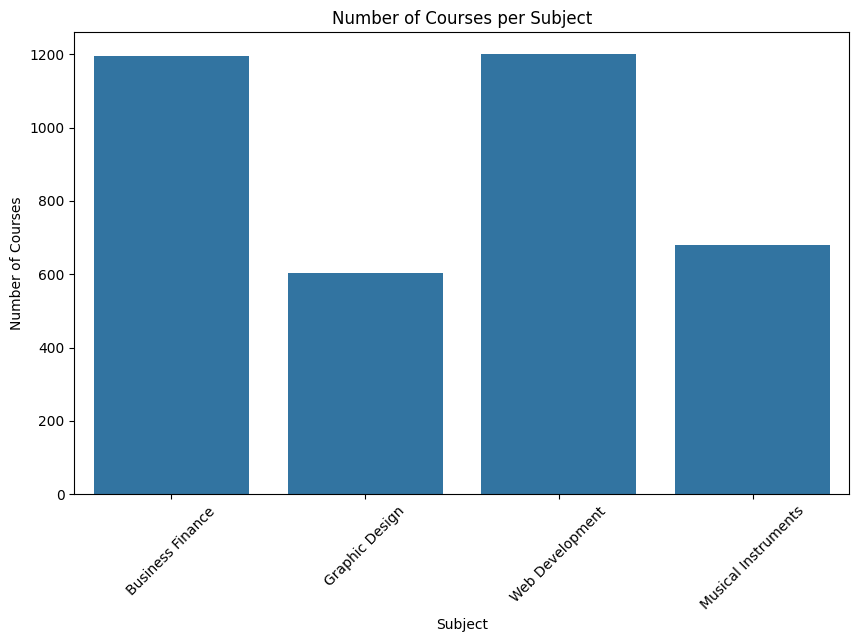

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
pdf_subject = df.groupBy("subject").count().toPandas()

# Plot the number of courses per subject
plt.figure(figsize=(10, 6))
sns.barplot(x="subject", y="count", data=pdf_subject)
plt.title("Number of Courses per Subject")
plt.xlabel("Subject")
plt.ylabel("Number of Courses")
plt.xticks(rotation=45)
plt.show()


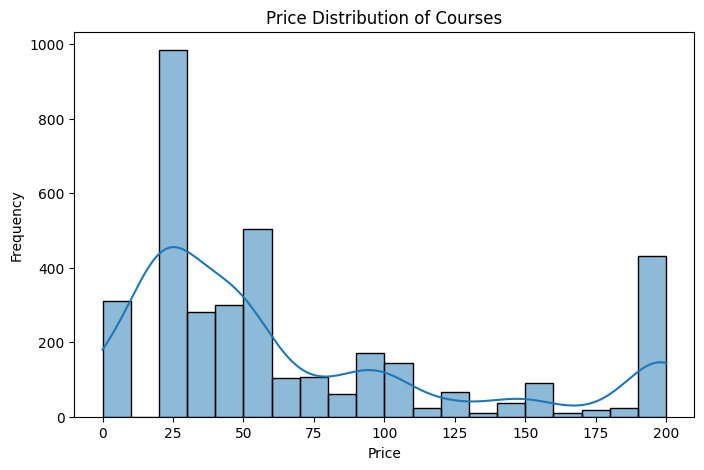

In [ ]:
# Convert price column to Pandas for visualization
pdf_price = df.select("price").toPandas()

# Plot the distribution of prices
plt.figure(figsize=(8, 5))
sns.histplot(pdf_price['price'], bins=20, kde=True)
plt.title("Price Distribution of Courses")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


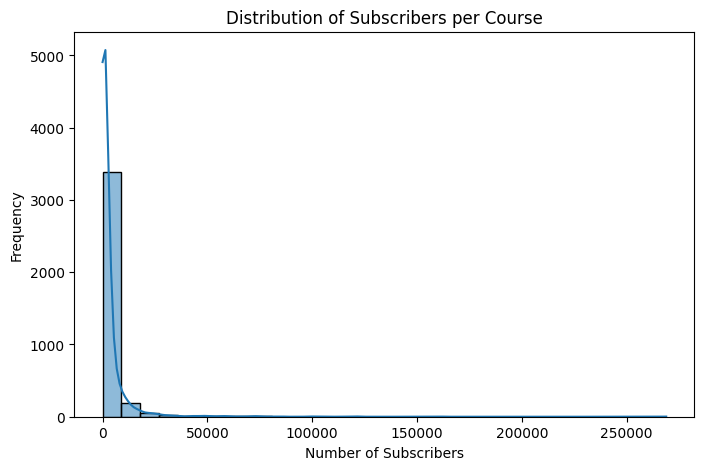

In [15]:
# Convert number of subscribers column to Pandas for visualization
pdf_subscribers = df.select("num_subscribers").toPandas()

# Plot the distribution of subscribers
plt.figure(figsize=(8, 5))
sns.histplot(pdf_subscribers['num_subscribers'], bins=30, kde=True)
plt.title("Distribution of Subscribers per Course")
plt.xlabel("Number of Subscribers")
plt.ylabel("Frequency")
plt.show()


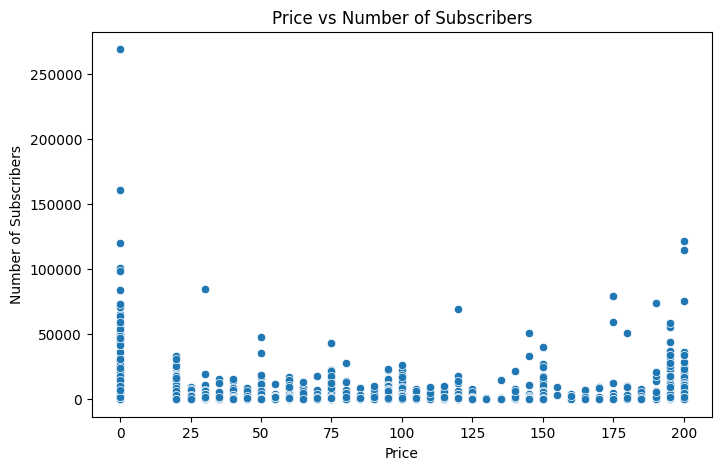

In [16]:
# Convert necessary columns to Pandas for visualization
pdf_price_subscribers = df.select("price", "num_subscribers").toPandas()

# Plot scatter plot of price vs number of subscribers
plt.figure(figsize=(8, 5))
sns.scatterplot(x="price", y="num_subscribers", data=pdf_price_subscribers)
plt.title("Price vs Number of Subscribers")
plt.xlabel("Price")
plt.ylabel("Number of Subscribers")
plt.show()


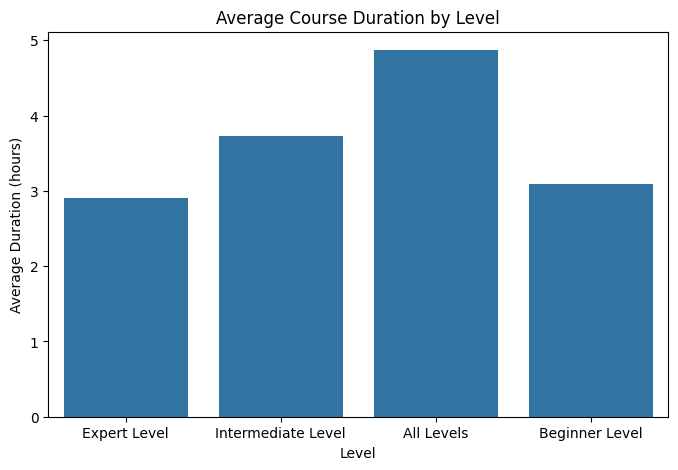

In [17]:
# Group by level and calculate average duration
pdf_duration_level = df.groupBy("level").avg("content_duration").toPandas()

# Plot the average duration by level
plt.figure(figsize=(8, 5))
sns.barplot(x="level", y="avg(content_duration)", data=pdf_duration_level)
plt.title("Average Course Duration by Level")
plt.xlabel("Level")
plt.ylabel("Average Duration (hours)")
plt.show()


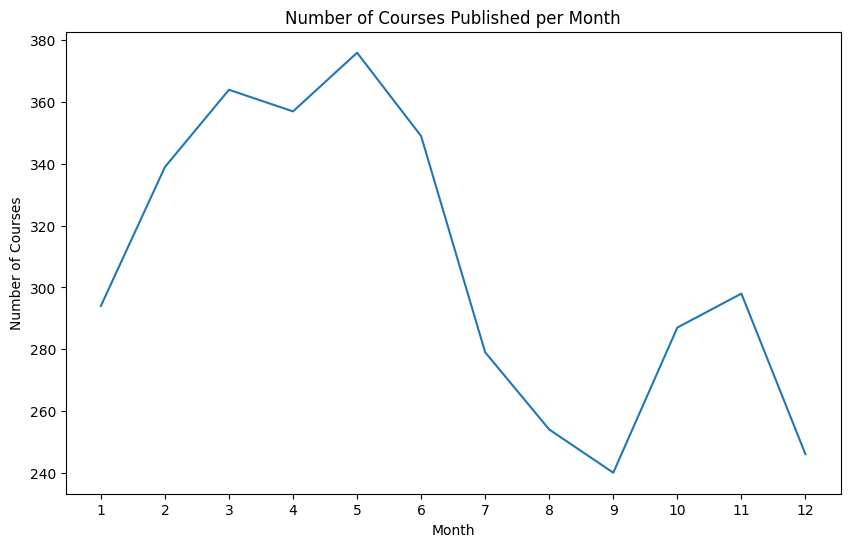

In [18]:
from pyspark.sql.functions import month

# Extract the month from the published timestamp
df = df.withColumn("month", month(df.published_timestamp))

# Group by month and count number of courses published
pdf_courses_per_month = df.groupBy("month").count().toPandas()

# Plot the number of courses published per month
plt.figure(figsize=(10, 6))
sns.lineplot(x="month", y="count", data=pdf_courses_per_month)
plt.title("Number of Courses Published per Month")
plt.xlabel("Month")
plt.ylabel("Number of Courses")
plt.xticks(range(1, 13))  # Months 1 to 12
plt.show()


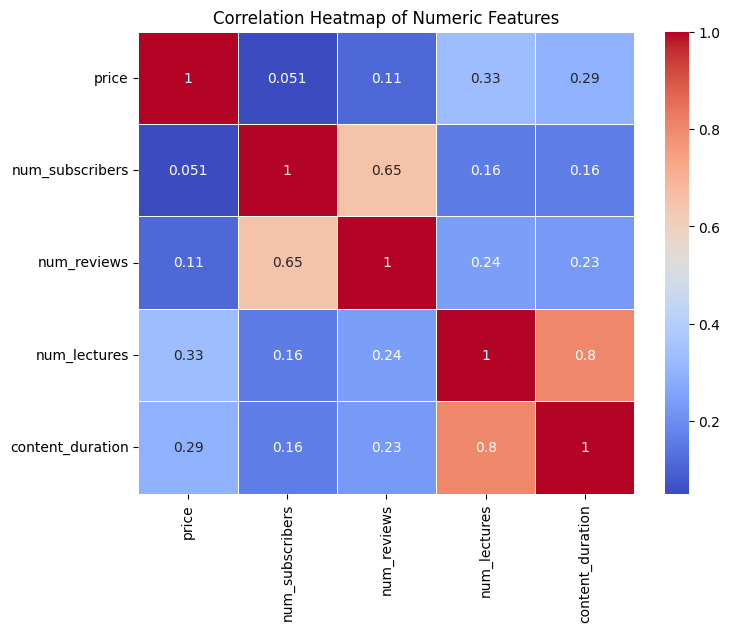

In [19]:
# Convert DataFrame to Pandas for heatmap visualization
pdf_numeric = df.select("price", "num_subscribers", "num_reviews", "num_lectures", "content_duration").toPandas()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pdf_numeric.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [20]:
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F
from pyspark.sql import Row

# ALS requires numeric user and item IDs. Create dummy user IDs based on unique course titles.
# In real-world scenarios, you'd use actual user data.
df = df.withColumn("user_id", F.monotonically_increasing_id())

# ALS expects the following columns: userId, itemId (courseId), and rating (can use num_subscribers as proxy).
df_als = df.select(F.col("user_id").alias("userId"),
                   F.col("course_id").alias("itemId"),
                   F.col("num_subscribers").alias("rating"))

df_als.show(5)


+------+-------+------+
|userId| itemId|rating|
+------+-------+------+
|     0|1070968|  2147|
|     1|1113822|  2792|
|     2|1006314|  2174|
|     3|1210588|  2451|
|     4|1011058|  1276|
+------+-------+------+
only showing top 5 rows



In [23]:
# Show predictions to check if they are being generated
predictions.show(5)

# Filter out rows with NaN predictions (if any exist)
predictions = predictions.filter(predictions.prediction.isNotNull())


+------+------+------+----------+
|userId|itemId|rating|prediction|
+------+------+------+----------+
+------+------+------+----------+



In [24]:
# Re-split the data, ensuring valid records in both sets
(training, test) = df_als.randomSplit([0.8, 0.2], seed=42)


In [26]:
# Check if the predictions DataFrame is empty
print(f"Number of rows in predictions: {predictions_filtered.count()}")


Number of rows in predictions: 0


In [27]:
# Get unique users and items in the training set
train_users = training.select("userId").distinct()
train_items = training.select("itemId").distinct()

# Check if users and items in the test set exist in the training set
test_users = test.select("userId").distinct()
test_items = test.select("itemId").distinct()

# Find test users and items not present in training
missing_users = test_users.subtract(train_users)
missing_items = test_items.subtract(train_items)

print(f"Missing users: {missing_users.count()}")
print(f"Missing items: {missing_items.count()}")


Missing users: 683
Missing items: 681


In [29]:
# Re-split the data, ensuring overlap between training and test sets
(training, test) = df_als.randomSplit([0.8, 0.2], seed=42)


In [31]:
# Train and test on the same data to ensure the model works
(training, test) = df_als.randomSplit([0.8, 0.2], seed=42)

# Train the ALS model
model = als.fit(training)

# Test on the same data to see if predictions are generated
predictions = model.transform(training)

# Filter out NaN predictions and evaluate
predictions_filtered = predictions.filter(predictions.prediction.isNotNull())
rmse = evaluator.evaluate(predictions_filtered)
print(f"Root Mean Square Error (RMSE) = {rmse}")


Root Mean Square Error (RMSE) = 0.01884006108522701


In [32]:
# Save the ALS model
model.save("course_recommendation_als_model")


In [33]:
# Load the previously saved model
from pyspark.ml.recommendation import ALSModel

loaded_model = ALSModel.load("course_recommendation_als_model")


In [34]:
# Generate top 5 course recommendations for each user
user_recommendations = loaded_model.recommendForAllUsers(5)

# Display recommendations for a specific user
user_id = 1  # Replace with a valid user ID from your dataset
user_recommendations.filter(user_recommendations.userId == user_id).show(truncate=False)


+------+------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                       |
+------+------------------------------------------------------------------------------------------------------+
|1     |[{41295, 102632.98}, {59014, 47254.188}, {65330, 45627.945}, {437398, 27440.896}, {289230, 27242.887}]|
+------+------------------------------------------------------------------------------------------------------+

